# Real World Project for AllCorrect Games

> [AllCorrect Games](https://allcorrectgames.com/) company constantly needs to monitor end-user feedback related to localization. The project aimed to develop a model that accurately predicts the localization sentiment in a fully automated manner.

- toc: true
- badges: true
- comments: true
- categories: [Machine Learning, Python, exploratory analysis, NLP, Sentiment Analysis, text processing, lemmatization, pandas, numpy, mathplotlib, scikit-learn, wordcloud, nltk, catboost, tensorflow, tf2, keras, bert, bert-for-tf2]
- image: images/all_correct.PNG

# Project Description

The company *Allcorrect Games* provides video game localization, localization testing, voiceovers, game art, and playable ads.

Allcorrect Group works with major international game publishers and developers. The company has participated in the localization of over 968 games, as well as the testing of over 100 games. Allcorrect Group works in more than 23 language pairs, partners with 6 voice studios, and employs highly competent native speakers to test games on the iOS, Android, and PC platforms.

The company uses players' reviews from different sources (Google PlayMarket,
AppStore, etc.) to find games with high localization demand. This information is
used to generate business offers from the company to game developers.

During reviews' analysis each of them is manually classified into several different categories. For instance, a review contains localization request or a user complains about translation mistakes, etc. Manual labeling of reviews is tedious and expensive process.

Main assumption of this project is that labeling could be done automatically by
machine learning algorithms.

## Task

Build an algorithm for classification of user reviews into one of the four categories. The quality of the algorithm should be evaluated using hold-out subset or cross-validation technique.


## Data Description

The dataset has a record of 58000 entries.

Each entry has:
* `id` : Unique ID for record entry
* `mark` : Corresponding label/tag category for text review entry
* `review` : Text review

The following are the unique `mark` category:
* `RL` : localization request
* `L+` : good/positive localization
* `L-` : bad/negative localization
* `YL` : localization exists 

## Metrics

The following metrics will be used to evaluate the model based on the prediction for the four unique categories:
* Accuracy score
* Macro F1 score

Using a macro F1 score, a macro-average will calculate the F1 score independently for each category/class and then take the average (treating all classes equally).


# Import Libraries

Create environment


In [ ]:
#collapse-output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import time

from collections import defaultdict
from wordcloud import WordCloud
import random

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords
nltk_data_path = os.path.join(os.path.dirname(nltk.__file__), 'nltk_data')
nltk.data.path.append(nltk_data_path)
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import decomposition, ensemble
from sklearn.metrics import make_scorer, accuracy_score, f1_score, classification_report

!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
import catboost
from catboost import CatBoostClassifier, Pool, metrics, cv
from catboost.text_processing import Tokenizer, Dictionary

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding
import tensorflow_hub as hub
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from tensorflow.keras.models import save_model, load_model

!pip install bert-for-tf2
from bert import bert_tokenization

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
     |████████████████████████████████| 69.2MB 50kB/s 
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# Exploratory data analysis

## Load Data

In [ ]:
from google.colab import drive, files
drive.mount('/content/gdrive')
!ls '/content/gdrive/My Drive/AllcorrectGames/'


df_reviews = pd.read_excel('/content/gdrive/My Drive/AllcorrectGames/reviews.xlsx')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
custom_w2v_100d.txt  keras_bert_model  reviews.xlsx  sample_file.xlsx


In [ ]:
def get_information(df):
    print('Head:')
    print()
    display(df.head())
    print ('-'*100)
    print('Info:')
    print()
    display(df.info())
    print ('-'*100)
    print('Describe:')
    print()
    display(df.describe())
    print ('-'*100)
    print()
    print('Columns with nulls:')
    display(get_precent_of_na_df(df,4))
    print ('-'*100)
    print('Shape:')
    print(df.shape)
    print ('-'*100)
    print('Duplicated:')
    print('\033[1m' + 'We have {} duplicated rows.'.format(df.duplicated().sum()) + '\033[0m')
    
def get_precent_of_na_df(df,num):
    df_nulls = pd.DataFrame(df.isna().sum(),columns=['Missing Values'])
    df_nulls['Percent of Nulls'] = round(df_nulls['Missing Values'] / df.shape[0],num) *100
    return df_nulls

In [ ]:
#collapse-output
get_information(df_reviews)

Head:



,id,mark,review
0,6720,RL,"It's not Turkish, it's a lie, but I recommend ..."
1,43313,RL,You don't have Korean
2,26549,RL,"Very nice, only if it were in Italian it would..."
3,42306,RL,The game is nice but when it comes to Turkish ...
4,32331,RL,"Amazing work, hope to achieve 100% Chinese tra..."


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51800 entries, 0 to 51799
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      51800 non-null  int64 
 1   mark    51800 non-null  object
 2   review  51800 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


None

----------------------------------------------------------------------------------------------------
Describe:



,id
count,51800.000000
mean,25918.529459
std,14964.874328
min,1.000000
25%,12959.750000
50%,25916.500000
75%,38879.250000
max,51840.000000


----------------------------------------------------------------------------------------------------

Columns with nulls:


,Missing Values,Percent of Nulls
id,0,0.0
mark,0,0.0
review,0,0.0


----------------------------------------------------------------------------------------------------
Shape:
(51800, 3)
----------------------------------------------------------------------------------------------------
Duplicated:
We have 0 duplicated rows.


There are 51800 entries with no null values. `mark` column has the tags for the targeted categories and none are missing for each review.

## Preprocessing Data

### Target Label Column

In [ ]:
display(df_reviews['mark'].unique())

array(['RL', 'YL', 'L+', 'L-', 'Rl', 'l-', 'Yl', 'yl'], dtype=object)

Need to clean up the target `mark` columns to have 4 categories: 
* `RL` 
* `YL`
* `L+`
* `L-`

In [ ]:
df_reviews['mark'] = df_reviews['mark'].str.upper()
display(df_reviews['mark'].unique())

array(['RL', 'YL', 'L+', 'L-'], dtype=object)

### Normalization of Feature text

In [ ]:
# Function to lowercase, remove digits, punctuations marks etc. from text

def clear_text(text):
    clean_text = re.sub(r'[^a-zA-z\']',' ',text)
    clean_text = ' '.join(clean_text.split())
    clean_text = clean_text.lower()

    return(clean_text)

In [ ]:
#collapse-hide
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
# Function to expand contractions in text

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [ ]:
df = df_reviews.copy()
df['review_norm'] = df['review'].apply(clear_text)
df['review_norm'] = df['review_norm'].apply(expand_contractions)

In [ ]:
df[['review','review_norm']].head()

,review,review_norm
0,"It's not Turkish, it's a lie, but I recommend ...",it is not turkish it is a lie but i recommend ...
1,You don't have Korean,you do not have korean
2,"Very nice, only if it were in Italian it would...",very nice only if it were in italian it would ...
3,The game is nice but when it comes to Turkish ...,the game is nice but when it comes to turkish ...
4,"Amazing work, hope to achieve 100% Chinese tra...",amazing work hope to achieve chinese translation



### Tokenize with Catboost Tokenizer

In [ ]:
# Tokenize text
# Removing punctuation and lowercases within Catboost Tokenizer
# (Feature normalize text already has this completed but Catboost has option in Tokenizer)
tokenizer = Tokenizer(
    lowercasing=True,
    separator_type='BySense',
    token_types=['Word', 'Number']
)

df['tokenized_text'] = [tokenizer.tokenize(text) for text in df['review_norm']]
df[['review_norm', 'tokenized_text']].head()

,review_norm,tokenized_text
0,it is not turkish it is a lie but i recommend ...,"[it, is, not, turkish, it, is, a, lie, but, i,..."
1,you do not have korean,"[you, do, not, have, korean]"
2,very nice only if it were in italian it would ...,"[very, nice, only, if, it, were, in, italian, ..."
3,the game is nice but when it comes to turkish ...,"[the, game, is, nice, but, when, it, comes, to..."
4,amazing work hope to achieve chinese translation,"[amazing, work, hope, to, achieve, chinese, tr..."


### Lemmatization

In [ ]:
# Lemmatization

# Maps POS tag for any word types and returns noun
def get_wordnet_pos(word): 
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, 
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

# Lemmatize text to noun based
def lemmatize_tokens_nltk(tokens):
    lemmatized_text = []
    for word in tokens:
        lemmatized_text.append(str(lemmatizer.lemmatize(word, get_wordnet_pos(word))))

    return ' '.join(lemmatized_text)


df['text_lemma_nltk'] = df['tokenized_text'].apply(lambda x: lemmatize_tokens_nltk(x))

In [ ]:
df[['review_norm', 'text_lemma_nltk']].head()

,review_norm,text_lemma_nltk
0,it is not turkish it is a lie but i recommend ...,it be not turkish it be a lie but i recommend ...
1,you do not have korean,you do not have korean
2,very nice only if it were in italian it would ...,very nice only if it be in italian it would be...
3,the game is nice but when it comes to turkish ...,the game be nice but when it come to turkish l...
4,amazing work hope to achieve chinese translation,amaze work hope to achieve chinese translation


## Visualize

### Label/Mark distribution

In [ ]:
# Function to get annotations on bar graphs

def get_annotation(ax):
  """Get annotation for graphs on top of bar graphs"""
  for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.05))

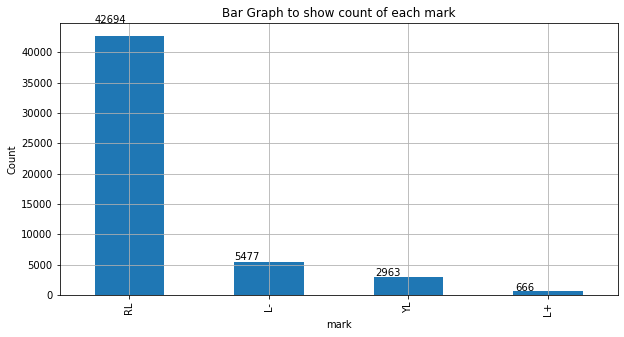

In [ ]:
# Plot counts for each mark

get_annotation(df['mark'].value_counts().plot(kind ='bar', 
                                              title = 'Bar Graph to show count of each mark', 
                                              align = 'center', figsize=(10,5)))
plt.ylabel('Count')
plt.xlabel('mark')
plt.grid(True)
plt.show()

Clearly, just as what was seen with the means, there is a larger count of `RL` maker in comparison to the others. `RL` has over 40,000 counts. `L-` has about 5,400 counts, YL has about 2,900 counts, and `L+` has about 600 counts. This shows a class imbalance for sure with `RL` having the highest majority.




### Length of Reviews

In [ ]:
df['review_length'] = df['review_norm'].apply(lambda x: len(str(x).split()))
df.describe()

,id,review_length
count,51800.000000,51800.000000
mean,25918.529459,33.011680
std,14964.874328,85.466875
min,1.000000,0.000000
25%,12959.750000,8.000000
50%,25916.500000,15.000000
75%,38879.250000,30.000000
max,51840.000000,3308.000000


There are reviews with word length of 0. 

In [ ]:
df.loc[df['review_length'] <= 0]

,id,mark,review,review_norm,tokenized_text,text_lemma_nltk,review_length
968,6284,RL,??,,[],,0
2778,45703,RL,.,,[],,0
6538,1037,RL,...,,[],,0
8779,47782,YL,👍👍👍,,[],,0
13292,12229,RL,😕😕😕,,[],,0
14029,47768,RL,..,,[],,0
23782,43514,RL,🙏🏽,,[],,0
26259,27730,RL,🇩🇰✌️,,[],,0
34109,31822,RL,，,,[],,0
37024,33813,RL,"По мотивам. Вы должны добавить польский, если ...",,[],,0


It would be ideal to drop these reviews that have 0 word length.

In [ ]:
df = df.loc[(df.review_length != 0)]

df.loc[df['review_length'] <= 0]

,id,mark,review,review_norm,tokenized_text,text_lemma_nltk,review_length


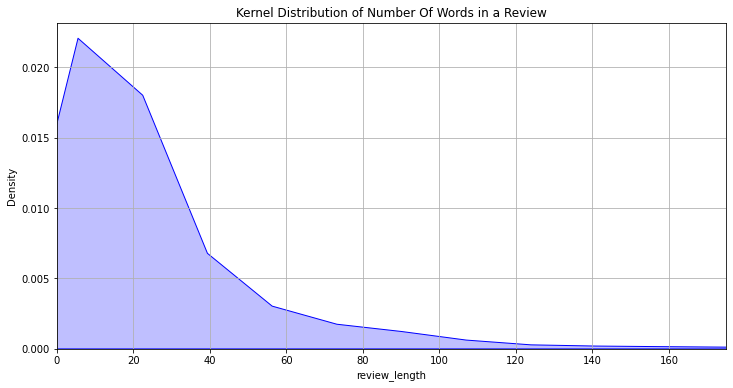

In [ ]:
# Plot word length density for reviews

plt.figure(figsize=(12,6))
plt.xlim(right=175)
plt.grid(True)
p1=sns.kdeplot(df['review_length'], shade=True, color='b').set_title('Kernel Distribution of Number Of Words in a Review')

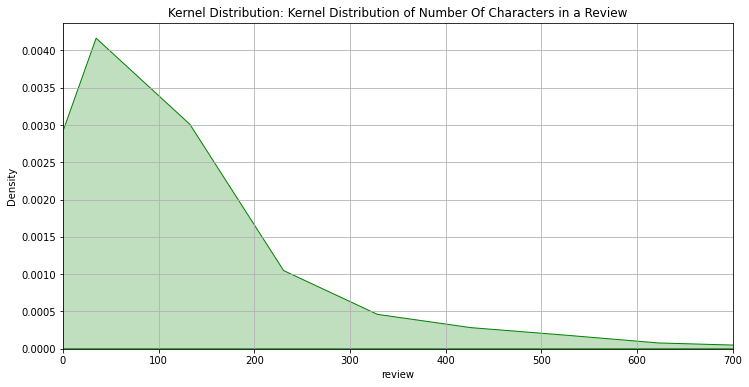

In [ ]:
# Plot Character length density for reviews

plt.figure(figsize=(12,6))
plt.xlim(right=700)
plt.grid(True)
p1=sns.kdeplot(df['review'].astype('str').apply(len), 
               shade=True,
               color='g').set_title('Kernel Distribution: Kernel Distribution of Number Of Characters in a Review')

Review with word length < 0 were removed. Both review lengths of word and character distribution is right-skewed. Most reviews have around 12-13 words in length and around 50 chracters.

### Most Frequent Unigram Words (N=1)

In [ ]:
stop_words = set(nltk_stopwords.words('english'))

In [ ]:
df['temp_list'] = df['review_norm'].apply(lambda x:str(x).split())

In [ ]:
# Remove stopwords from the articles
def remove_stopword(x):
    return [word for word in x if word not in stop_words]


df['temp_list_stopw'] = df['temp_list'].apply(lambda x:remove_stopword(x))

In [ ]:
# Generate n-gram words
def generate_ngrams(text, n_gram=1):
    ngrams = zip(*[text[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

review_unigrams = defaultdict(int)

for x in df['temp_list_stopw']:
    for word in generate_ngrams(x):
        review_unigrams[word] += 1

df_review_unigrams = pd.DataFrame(sorted(review_unigrams.items(), key=lambda x: x[1])[::-1])

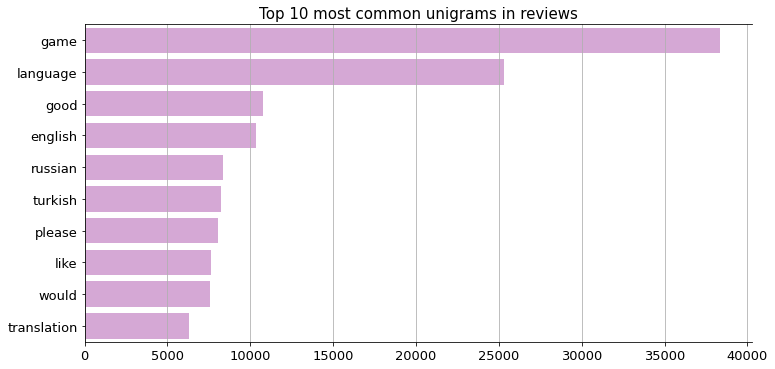

In [ ]:
#collapse-hide
# Bar graph of top N common unigram in reviews
N=10
fig, axes = plt.subplots(figsize=(10, 5))
plt.tight_layout()
plt.grid(True)
sns.barplot(y=df_review_unigrams[0].values[:N], x=df_review_unigrams[1].values[:N], color='plum')
axes.spines['right'].set_visible(False)
axes.set_xlabel('')
axes.set_ylabel('')
axes.tick_params(axis='x', labelsize=13)
axes.tick_params(axis='y', labelsize=13)
axes.set_title(f'Top {N} most common unigrams in reviews', fontsize=15)
plt.show()

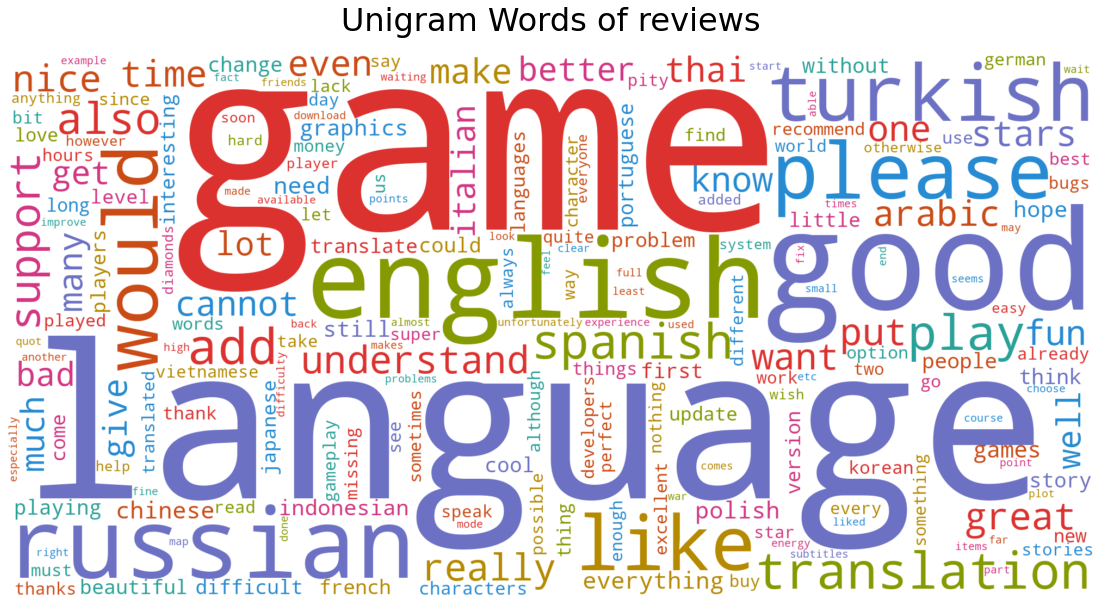

In [ ]:
#collapse-hide
# Plot word cloud
def col_func(word, font_size, position, orientation, font_path, random_state):
    colors = ['#b58900', '#cb4b16', '#dc322f', '#d33682', '#6c71c4',
              '#268bd2', '#2aa198', '#859900']
    return random.choice(colors)
fd = {
    'fontsize': '32',
    'fontweight' : 'normal',
    'verticalalignment': 'baseline',
    'horizontalalignment': 'center',
}
wc = WordCloud(width=2000, height=1000, collocations=False,
               background_color="white",
               color_func=col_func,
               max_words=200,
               random_state=RANDOM_STATE) .generate_from_frequencies(review_unigrams)
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wc, interpolation='bilinear')
ax.axis("off")
ax.set_title('Unigram Words of reviews', pad=24, fontdict=fd)
plt.show()

In the unigram, it seems the most common words points to good, language, and game. Russian and Turkish is also shows up frequently too as unigrams.

### Most Frequent Bigram Words (N=2)

In [ ]:
review_bigrams = defaultdict(int)

for i in df['temp_list_stopw']:
    for word in generate_ngrams(i, n_gram=2):
        review_bigrams[word] += 1

df_review_bigrams=pd.DataFrame(sorted(review_bigrams.items(), key=lambda x: x[1])[::-1])

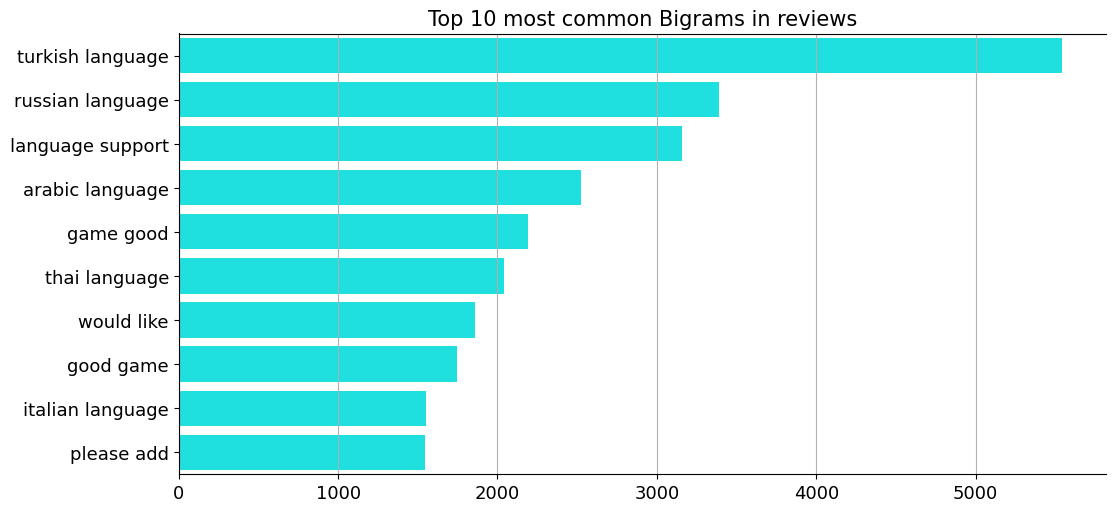

In [ ]:
#collapse-hide
# Bar graph of top N bigram words
N=10
fig, axes = plt.subplots(figsize=(10, 5), dpi=100)
plt.tight_layout()
plt.grid(True)
sns.barplot(y=df_review_bigrams[0].values[:N],
            x=df_review_bigrams[1].values[:N], 
            color='aqua')
axes.spines['right'].set_visible(False)
axes.set_xlabel('')
axes.set_ylabel('')
axes.tick_params(axis='x', labelsize=13)
axes.tick_params(axis='y', labelsize=13)
axes.set_title(f'Top {N} most common Bigrams in reviews', fontsize=15)
plt.show()

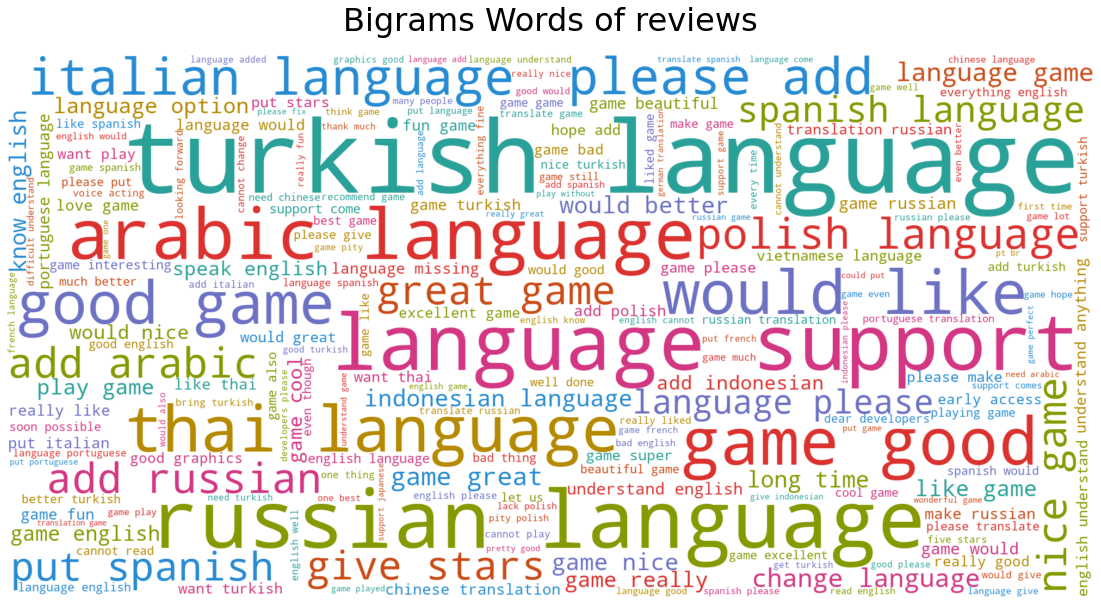

In [ ]:
#collapse-hide
#Word cloud
wc = WordCloud(width=2000, height=1000, collocations=False,
               background_color='white',
               color_func=col_func,
               max_words=200,
               random_state=RANDOM_STATE)\
               .generate_from_frequencies(review_bigrams)
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wc, interpolation='bilinear')
ax.axis('off')
ax.set_title('Bigrams Words of reviews', pad=24,
             fontdict=fd)
plt.show()

Bigram gives a bit more context in comparison to unigram. There seems to be more language requests that can be seen.

# Split Data

In [ ]:
target = df['mark']
features = df['text_lemma_nltk']

cols_target = ['L+', 'L-', 'RL', 'YL']

In [ ]:
# Split the dataset into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.20, random_state=RANDOM_STATE, stratify=target)

assert x_train.shape[0] == y_train.shape[0]
assert x_test.shape[0] == y_test.shape[0]

print('Train:', x_train.shape, ' Target Train:', y_train.shape)
print('Test:', x_test.shape, ' Target Test:', y_test.shape)

Train: (41428,)  Target Train: (41428,)
Test: (10358,)  Target Test: (10358,)


Since cross-validation is used no validation sub-dataset is needed. 

In [ ]:
# Label encode the target variable 
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

`LabelEncoder` is applied to the target column to normalize labels/marks.

# Feature text Engineering

Feature text data will be transformed into feature vectors.

## Count Vectors as features

Count Vector is a matrix notation of the dataset in which every row represents a document from the corpus, every column represents a term from the corpus, and every cell represents the frequency count of a particular term in a particular document.

In [ ]:
# Create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df['text_lemma_nltk'])

# Transform the training and validation data using count vectorizer object
x_train_count = count_vect.transform(x_train)
x_test_count = count_vect.transform(x_test)

## TF-IDF Vectors as features

TF-IDF score represents the relative importance of a term in the document and the entire corpus. TF-IDF score is composed by two terms: the first computes the normalized Term Frequency (TF), the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

$${TF(t)} = \frac{\textsf{Number of times term t appears in a document}}{\textsf{Total number of terms in the document}}$$


$${IDF(t)} = log_e(
\frac{\textsf{Total number of documents}}{\textsf{Number of documents with term t in it}})$$

TF-IDF Vectors can be generated at different levels of input tokens (words, characters, n-grams)

* **Word Level TF-IDF** : Matrix representing tf-idf scores of every term in different documents
* **N-gram Level TF-IDF** : N-grams are the combination of N terms together. This Matrix representing tf-idf scores of N-grams
* **Character Level TF-IDF** : Matrix representing tf-idf scores of character level n-grams in the corpus

In [ ]:
# Word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df['text_lemma_nltk'])

x_train_tfidf =  tfidf_vect.transform(x_train)
x_test_tfidf =  tfidf_vect.transform(x_test)

# N-gram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(df['text_lemma_nltk'])

x_train_tfidf_ngram =  tfidf_vect_ngram.transform(x_train)
x_test_tfidf_ngram =  tfidf_vect_ngram.transform(x_test)

# Characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(df['text_lemma_nltk'])

x_train_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_train) 
x_test_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_test) 

## Hstacking Text / NLP features with text feature vectors



In [ ]:
vectorizer = FeatureUnion([ 
                           ('count_vect', CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')),
                           #('tfidf_vect', TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)), 
                           #('tfidf_vect_ngram', TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)),
                           ('tfidf_vect_ngram_chars', TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000))
])

vectorizer.fit(df['text_lemma_nltk'])

x_train_vect_combo = vectorizer.transform(x_train)
x_test_vect_combo = vectorizer.transform(x_test)

# Model Building

In [ ]:
def train_model(classifier, feature_vector_train, feature_vector_test, target_train, target_test, is_neural_net=False):
    # fit the training dataset on the classifier
    %time classifier.fit(feature_vector_train, target_train)
    
    # predict the target on test dataset
    predictions = classifier.predict(feature_vector_test)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    kfold = KFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)

    acc = cross_val_score(classifier, feature_vector_train, target_train, cv=kfold).mean()
    f1 = cross_val_score(classifier, feature_vector_train, target_train, cv=kfold, scoring='f1_macro').mean()
    
    print()
    print('Cross validation Accuracy score: {}'.format(acc))
    print('Cross validation F1 macro score: {}'.format(f1))
    print()
    print(classification_report(target_test, predictions, target_names=cols_target))

## Base Model: Logistic Regression

In [ ]:
logreg = LogisticRegression(multi_class = 'multinomial', 
                            solver='newton-cg')

In [ ]:
# Logistic Regression on Count Vectors
print('LR, Count Vectors: ')
train_model(logreg, x_train_count, x_test_count, y_train, y_test)

LR, Count Vectors: 
CPU times: user 48.8 s, sys: 38.2 s, total: 1min 27s
Wall time: 44.4 s

Cross validation Accuracy score: 0.8950949394977474
Cross validation F1 macro score: 0.6119392413618302

              precision    recall  f1-score   support

          L+       0.45      0.32      0.38       133
          L-       0.81      0.71      0.76      1096
          RL       0.93      0.97      0.95      8537
          YL       0.58      0.40      0.47       592

    accuracy                           0.90     10358
   macro avg       0.69      0.60      0.64     10358
weighted avg       0.89      0.90      0.90     10358



In [ ]:
# Logistic Regression on Word level TF-IDF Vectors
print('LR, Word level TF-IDF Vectors: ')
train_model(logreg, x_train_tfidf, x_test_tfidf, y_train, y_test)

LR, Word level TF-IDF Vectors: 
CPU times: user 6.82 s, sys: 5.28 s, total: 12.1 s
Wall time: 6.21 s

Cross validation Accuracy score: 0.9007434284672972
Cross validation F1 macro score: 0.5612290615815929

              precision    recall  f1-score   support

          L+       0.80      0.06      0.11       133
          L-       0.80      0.73      0.76      1096
          RL       0.93      0.98      0.95      8537
          YL       0.75      0.36      0.48       592

    accuracy                           0.91     10358
   macro avg       0.82      0.53      0.58     10358
weighted avg       0.90      0.91      0.89     10358



In [ ]:
# Logistic Regression on Ngram level TF-IDF Vectors
print('LR, Ngram level TF-IDF Vectors: ')
train_model(logreg, x_train_tfidf_ngram, x_test_tfidf_ngram, y_train, y_test)

LR, Ngram level TF-IDF Vectors: 
CPU times: user 5.85 s, sys: 4.56 s, total: 10.4 s
Wall time: 5.37 s

Cross validation Accuracy score: 0.8901467293794232
Cross validation F1 macro score: 0.5246856160591294

              precision    recall  f1-score   support

          L+       0.70      0.05      0.10       133
          L-       0.78      0.62      0.69      1096
          RL       0.91      0.98      0.94      8537
          YL       0.76      0.29      0.42       592

    accuracy                           0.89     10358
   macro avg       0.79      0.49      0.54     10358
weighted avg       0.88      0.89      0.88     10358



In [ ]:
# Logistic Regression on Ngram Character level TF-IDF Vectors
print('LR, Ngram Character level TF-IDF Vectors: ')
train_model(logreg, x_train_tfidf_ngram_chars, x_test_tfidf_ngram_chars, y_train, y_test)

LR, Ngram Character level TF-IDF Vectors: 
CPU times: user 31.9 s, sys: 22.2 s, total: 54.1 s
Wall time: 29.1 s

Cross validation Accuracy score: 0.8971709426622274
Cross validation F1 macro score: 0.5497170658507233

              precision    recall  f1-score   support

          L+       0.64      0.07      0.12       133
          L-       0.77      0.72      0.74      1096
          RL       0.93      0.98      0.95      8537
          YL       0.73      0.35      0.48       592

    accuracy                           0.90     10358
   macro avg       0.77      0.53      0.57     10358
weighted avg       0.89      0.90      0.89     10358



In [ ]:
# Logistic Regression on Count, Ngram Charcter level TF-IDF Vectors
print('LR, Count, Ngram Charcter level TF-IDF Vectors: ')
train_model(logreg, x_train_vect_combo, x_test_vect_combo, y_train, y_test)

LR, Count, Ngram Charcter level TF-IDF Vectors: 
CPU times: user 3min 29s, sys: 2min 13s, total: 5min 43s
Wall time: 3min 13s

Cross validation Accuracy score: 0.9014675356022206
Cross validation F1 macro score: 0.632361706349813

              precision    recall  f1-score   support

          L+       0.48      0.34      0.40       133
          L-       0.82      0.72      0.77      1096
          RL       0.94      0.97      0.95      8537
          YL       0.65      0.46      0.54       592

    accuracy                           0.91     10358
   macro avg       0.72      0.62      0.67     10358
weighted avg       0.90      0.91      0.90     10358



The table below shows a summary of this section for base model of Logistic Regression:

| Logistic Regression | *Parameters: multi_class = 'multinomial', solver='newton-cg'* |  |
|:--- |:--------------------| :--------------------|
| **Count Vectors:** | *Cross-Validation of 5 fold mean scores:*| *Testing dataset scores:* |
| Accuracy: | 0.895 | 0.90 |
| F1 Score (Macro): | 0.612 | 0.64 |
| |
| **Word level TF-IDF Vectors:** | *Cross-Validation of 5 fold mean scores:*| *Testing dataset scores:* |
| Accuracy: | 0.901 | 0.90 | 
| F1 Score (Macro): | 0.561 | 0.58 |
| | 
| **Ngram level TF-IDF Vectors:** | *Cross-Validation of 5 fold mean scores:*| *Testing dataset scores:* |
| Accuracy: | 0.890 | 0.89 |
| F1 Score (Macro): | 0.525 | 0.54 |
| |
| **Ngram Charcter level TF-IDF Vectors:** |  *Cross-Validation of 5 fold mean scores:*| *Testing dataset scores:* |
| Accuracy: | 0.897 | 0.90 |
| F1 Score (Macro): | 0.550 | 0.57 |
| |
| **Count, Ngram Charcter level TF-IDF Vectors:** | *Cross-Validation of 5 fold mean scores:*| *Testing dataset scores:* |
| Accuracy: | 0.901 | 0.91 |
| F1 Score (Macro): | 0.632 | 0.67 |

Based off the Count vectors' and Ngram Character level TF-IDF vectors' cross-validation scores, it was determined that these two feature vectors could be combined to see if the accuracy and F1 macro scores would increase and indeed these both scores did increase when both feature vectors were combined with Logistic Regression. Moving forward, we may only check Count vectors or the combined feature vector as some models take a long time to find cross-validaton scores.

### Over sample minority / Under sample majority

In [ ]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
#Method to upsample training sets on each fold
smote_pipeline = make_pipeline(SMOTE(random_state=RANDOM_STATE), 
                               LogisticRegression(multi_class = 'multinomial', 
                                                  solver='newton-cg'))

over_pipeline = make_pipeline(RandomOverSampler(sampling_strategy='minority'), 
                              LogisticRegression(multi_class = 'multinomial', 
                                                 solver='newton-cg'))


under_pipeline = make_pipeline(RandomUnderSampler(sampling_strategy='majority'), 
                               LogisticRegression(multi_class = 'multinomial', 
                                                  solver='newton-cg'))


In [ ]:
def get_cv_scores(pipeline, x_train, y_train):
  acc = %time cross_val_score(pipeline, x_train, y_train, cv=5, n_jobs=-1).mean()
  f1 = %time cross_val_score(pipeline, x_train, y_train, scoring='f1_macro', cv=5, n_jobs=-1).mean()

  print('Cross validation score: ', acc)
  print('Cross validation F1 macro score: ', f1)

In [ ]:
print('SMOTE - Synthetic Minority Over-sampling Technique (not majority)')
get_cv_scores(smote_pipeline, x_train_count, y_train)

SMOTE - Synthetic Minority Over-sampling Technique (not majority)
CPU times: user 5.85 s, sys: 969 ms, total: 6.82 s
Wall time: 19min 25s
CPU times: user 5.94 s, sys: 797 ms, total: 6.74 s
Wall time: 19min 23s
Cross validation score:  0.8415805939474295
Cross validation F1 macro score:  0.5601322921363983


In [ ]:
print('Random Over Sample (minority)')
get_cv_scores(over_pipeline, x_train_count, y_train)

Random Over Sample (minority)
CPU times: user 1.51 s, sys: 215 ms, total: 1.72 s
Wall time: 4min 49s
CPU times: user 1.48 s, sys: 197 ms, total: 1.68 s
Wall time: 4min 39s
Cross validation score:  0.8839431104460905
Cross validation F1 macro score:  0.5873712618711804


In [ ]:
print('Random Under Sample (majority)')
get_cv_scores(under_pipeline, x_train_count, y_train)

Random Under Sample (majority)
CPU times: user 205 ms, sys: 35.8 ms, total: 241 ms
Wall time: 31.6 s
CPU times: user 171 ms, sys: 21.7 ms, total: 193 ms
Wall time: 24.6 s
Cross validation score:  0.5309693980335767
Cross validation F1 macro score:  0.4159653917859837


In regards to correcting the class imbalance, it seems like the method of over sampling the minority did best. However, with using any of these methods it decreased both accuracy and F1 macro scores. It may not be worth moving forward with these methods if they have been shown to decrease both accuracy and F1 macro with cross-validation. 

| Logistic Regression with Count Vectors | Accuracy | F1 Macro |
|:--- |:---|:---|
| *Cross-Validation of 5 fold mean scores* |
| |
| With no sampling | 0.89509 | 0.61194 |
| Synthetic Minority Over-sampling Technique (SMOTE): | 0.84158 | 0.56013 |
| Random Over Sample (minority): | 0.88394 | 0.58737 | 
| Random Under Sample (majority): | 0.53097 | 0.41596 |

## Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=RANDOM_STATE, 
                            n_estimators=100, 
                            max_depth=100,
                            min_samples_leaf=2,
                            max_features=300,
                            class_weight='balanced')

In [ ]:
# Random Forest on Count Vectors
print('RF, Count Vectors: ')
train_model(rf, x_train_count, x_test_count, y_train, y_test)

RF, Count Vectors: 
CPU times: user 47.2 s, sys: 100 ms, total: 47.3 s
Wall time: 47.1 s

Cross validation Accuracy score: 0.8760741686284433
Cross validation F1 macro score: 0.5775907873660777

              precision    recall  f1-score   support

          L+       0.50      0.11      0.17       133
          L-       0.61      0.83      0.71      1096
          RL       0.95      0.94      0.94      8537
          YL       0.63      0.44      0.52       592

    accuracy                           0.89     10358
   macro avg       0.67      0.58      0.59     10358
weighted avg       0.89      0.89      0.88     10358



In [ ]:
# Random Forest on NLTK/TF-IDF, Count, Ngram level TF-IDF Vectors
print('RF, NLTK/TF-IDF, Count, Ngram level TF-IDF Vectors: ')
train_model(rf, x_train_vect_combo, x_test_vect_combo, y_train, y_test)

RF, NLTK/TF-IDF, Count, Ngram level TF-IDF Vectors: 
CPU times: user 2min 29s, sys: 251 ms, total: 2min 29s
Wall time: 2min 29s

Cross validation Accuracy score: 0.8780292648847748
Cross validation F1 macro score: 0.47457559490202045

              precision    recall  f1-score   support

          L+       0.40      0.02      0.03       133
          L-       0.66      0.68      0.67      1096
          RL       0.91      0.97      0.94      8537
          YL       0.87      0.13      0.23       592

    accuracy                           0.88     10358
   macro avg       0.71      0.45      0.47     10358
weighted avg       0.87      0.88      0.86     10358



Random Forest Classifer did not have better results than the base Logistic Regression model. 
The table below sums up the testing results we had for the Random Forest model. Perhaps better scores could be obtained through hyper parameterization but this can be expensive in regards to computational cost.

| Random Forest Classifier |  |  |
|:--- |:--------------------| :--------------------|
| *Parameters: random_state= 42, n_estimators=100, max_depth=100, min_samples_leaf=2, max_features=300, class_weight='balanced'* |
| |
| **Count Vectors:** | *Cross-Validation of 5 fold mean scores:*| *Testing dataset scores:* |
| Accuracy: | 0.876 | 0.89 |
| F1 Score (Macro): | 0.577 | 0.59 |
| |
| **Count, Ngram Charcter level TF-IDF Vectors:** | *Cross-Validation of 5 fold mean scores:*| *Testing dataset scores:* |
| Accuracy: | 0.878 | 0.88 |
| F1 Score (Macro): | 0.475 | 0.47 |

## SVM LinearSVC

In [ ]:
model_svc = LinearSVC(class_weight='balanced',
                      random_state=RANDOM_STATE,
                      max_iter=1000)

In [ ]:
# SVC on Count Vectors
print('SVC, Count Vectors: ')
train_model(model_svc, x_train_count, x_test_count, y_train, y_test)

SVC, Count Vectors: 
CPU times: user 14.9 s, sys: 11.1 ms, total: 14.9 s
Wall time: 14.9 s

Cross validation Accuracy score: 0.876122297158421
Cross validation F1 macro score: 0.5970908433767836

              precision    recall  f1-score   support

          L+       0.28      0.27      0.27       133
          L-       0.73      0.72      0.73      1096
          RL       0.94      0.94      0.94      8537
          YL       0.47      0.51      0.49       592

    accuracy                           0.88     10358
   macro avg       0.60      0.61      0.61     10358
weighted avg       0.89      0.88      0.88     10358



In [ ]:
 # SVC on NLTK/TF-IDF, Count, Ngram character level TF-IDF Vectors
print('SVC, NLTK/TF-IDF, Count, Ngram character level TF-IDF Vectors: ')
train_model(model_svc, x_train_vect_combo, x_test_vect_combo, y_train, y_test)

SVC, NLTK/TF-IDF, Count, Ngram character level TF-IDF Vectors: 
CPU times: user 1min 20s, sys: 159 ms, total: 1min 20s
Wall time: 1min 20s

Cross validation Accuracy score: 0.8842087583727837
Cross validation F1 macro score: 0.6116865676987674

              precision    recall  f1-score   support

          L+       0.37      0.32      0.34       133
          L-       0.75      0.73      0.74      1096
          RL       0.95      0.95      0.95      8537
          YL       0.49      0.54      0.51       592

    accuracy                           0.89     10358
   macro avg       0.64      0.63      0.64     10358
weighted avg       0.89      0.89      0.89     10358



Similar results to Random Forest model, the Linear SVC model did perform slightly better but not better than the base Logistic Regression model. Same issue we face with Random Forest where we might better scores through hyper parameterization but this can be expensive in regards to computational cost.



| Linear SVC |  |  |
|:--- |:---| :----|
| *Parameters: random_state= 42, class_weight='balanced', max_iter=1000'* |
| |
| **Count Vectors:** | *Cross-Validation of 5 fold mean scores:*| *Testing dataset scores:* |
| Accuracy: | 0.876 | 0.88 |
| F1 Score (Macro): | 0.597 | 0.61 |
| |
| **Count, Ngram Charcter level TF-IDF Vectors:** | *Cross-Validation of 5 fold mean scores:*| *Testing dataset scores:* |
| Accuracy: | 0.884 | 0.89 |
| F1 Score (Macro): |  0.612 | 0.64 |

## CatBoost Model

In [ ]:
cb = CatBoostClassifier(iterations=1000, 
                        task_type='GPU',
                        logging_level='Silent')

In [ ]:
# Catboost on Count Vectors
print('CB, Count Vectors: ')
train_model(cb, x_train_count, x_test_count, y_train, y_test)

CB, Count Vectors: 


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

CPU times: user 17min 47s, sys: 2.65 s, total: 17min 50s
Wall time: 9min 29s

Cross validation Accuracy score: 0.8920535572650119
Cross validation F1 macro score: 0.5007487070760853

              precision    recall  f1-score   support

          L+       0.69      0.07      0.12       133
          L-       0.80      0.71      0.75      1096
          RL       0.91      0.99      0.95      8537
          YL       0.73      0.19      0.30       592

    accuracy                           0.90     10358
   macro avg       0.78      0.49      0.53     10358
weighted avg       0.89      0.90      0.88     10358



In [ ]:
# CatBoost on NLTK/TF-IDF, Count, Ngram level TF-IDF Vectors
print('Catboost, NLTK/TF-IDF, Count, Ngram level TF-IDF Vectors: ')
train_model(cb, x_train_vect_combo, x_test_vect_combo, y_train, y_test)

Catboost, NLTK/TF-IDF, Count, Ngram level TF-IDF Vectors: 
CPU times: user 1min 30s, sys: 34.7 s, total: 2min 5s
Wall time: 1min 20s

Cross validation Accuracy score: 0.899029542963963
Cross validation F1 macro score: 0.5505443023934945

              precision    recall  f1-score   support

          L+       0.67      0.09      0.16       133
          L-       0.79      0.74      0.76      1096
          RL       0.92      0.98      0.95      8537
          YL       0.76      0.29      0.42       592

    accuracy                           0.91     10358
   macro avg       0.78      0.53      0.57     10358
weighted avg       0.90      0.91      0.89     10358



With CatBoost Classifer, the metric scores for accuracy and F1 macro were better than both Random Forest and Linear SVC, but the F1 macro score is still a bit lower than base Logistic Regression model. With hyper parameterization, I am sure we can get high metric scores for CatBoost. However, just like the other previous models this can be expensive in regards to computational cost.



| CatBoost Classifier |  |  |
|:--- |:---| :---|
| *Parameters: iterations=1000, task_type='GPU', logging_level='Silent'* | 
| |
| **Count Vectors:** | *Cross-Validation of 5 fold mean scores:*| *Testing dataset scores:* |
| Accuracy: | 0.892 | 0.90 |
| F1 Score (Macro): | 0.500 | 0.53 |
| |
| **Count, Ngram Charcter level TF-IDF Vectors:** | *Cross-Validation of 5 fold mean scores:*| *Testing dataset scores:* |
| Accuracy: | 0.899 | 0.91 |
| F1 Score (Macro): | 0.551 | 0.57 |

## Keras Deep Learning Model 
---
BERT Embeddings with TensorFlow 2 (bert-for-tf2)

### BERT Word Embeddings

In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
# create a tokenizer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

# create token-embedding mapping
def bert_encode(texts, tokenizer, max_len=512):
  all_tokens = []
  all_masks = []
  all_segments = []
  
  for text in texts:
    # tokenize text
    text = tokenizer.tokenize(text)

    # convert text to sequence of tokens and pad them to ensure equal length vectors
    text = text[:max_len-2]
    input_sequence = ["[CLS]"] + text + ["[SEP]"]
    pad_len = max_len - len(input_sequence)
        
    tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
    pad_masks = [1] * len(input_sequence) + [0] * pad_len
    segment_ids = [0] * max_len
        
    all_tokens.append(tokens)
    all_masks.append(pad_masks)
    all_segments.append(segment_ids)
  
  return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

### Model

In [ ]:
def build_model(bert_layer, max_len=512):

  # Add an Input Layer
  input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
  input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
  segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

  # Add the BERT layer sequence output
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
  clf_output = sequence_output[:, 0, :]

  # Add the output Layers
  output_layer1 = tf.keras.layers.Dense(64, activation='relu')(clf_output)
  output_layer1 = tf.keras.layers.Dropout(0.2)(output_layer1)
  output_layer1 = tf.keras.layers.Dense(32, activation='relu')(output_layer1)
  output_layer1 = tf.keras.layers.Dropout(0.2)(output_layer1)
  output_layer2 = tf.keras.layers.Dense(4, activation='softmax')(output_layer1)
  
  # Compile the model
  model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=output_layer2)
  model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
  

  return model

In [ ]:
# Check only the first 150 characters of each review
max_len = 150

train_input = bert_encode(x_train, tokenizer, max_len=max_len)
test_input = bert_encode(x_test, tokenizer, max_len=max_len)

In [ ]:
# Number of classes/marks
num_classes = 4

train_labels = keras.utils.to_categorical(y_train, num_classes)
test_labels = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
# Build model
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 150)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 150)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/AllcorrectGames/model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_history = model.fit(
    train_input, train_labels, 
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1)

Epoch 1/3
1036/1036 [==============================] - 1118s 1s/step - loss: 0.3876 - accuracy: 0.8751 - val_loss: 0.2556 - val_accuracy: 0.9289

Epoch 00001: val_accuracy improved from -inf to 0.92892, saving model to model.h5
Epoch 2/3
1036/1036 [==============================] - 1104s 1s/step - loss: 0.2100 - accuracy: 0.9343 - val_loss: 0.2026 - val_accuracy: 0.9359

Epoch 00002: val_accuracy improved from 0.92892 to 0.93592, saving model to model.h5
Epoch 3/3
1036/1036 [==============================] - 1104s 1s/step - loss: 0.1538 - accuracy: 0.9530 - val_loss: 0.2093 - val_accuracy: 0.9405

Epoch 00003: val_accuracy improved from 0.93592 to 0.94050, saving model to model.h5


In [ ]:
model.load_weights('/content/gdrive/MyDrive/AllcorrectGames/model.h5')
test_pred = model.predict(test_input) # For netural_net this gives probabilities (proba)

# For neural_net to get predicted classes:
test_pred_ = test_pred.argmax(axis=-1)

print(classification_report(y_test, test_pred_, target_names=cols_target))

              precision    recall  f1-score   support

          L+       0.80      0.64      0.71       133
          L-       0.88      0.87      0.87      1096
          RL       0.97      0.98      0.97      8537
          YL       0.83      0.67      0.74       592

    accuracy                           0.95     10358
   macro avg       0.87      0.79      0.82     10358
weighted avg       0.95      0.95      0.95     10358



In [ ]:
# Save model
model.save('/content/gdrive/MyDrive/AllcorrectGames/keras_bert_model')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/AllcorrectGames/keras_bert_model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/AllcorrectGames/keras_bert_model/assets


The Keras model with bert-for-tf2 performed the best out of all the models tested. Fitting the model did take a bit long though the time shorten when ran with GPU over CPU (about 13 hours per epoch on CPU and about 15 minutes per epooch on GPU). 


| Keras model with bert-for-tf2 |  |  |
|:--- |:--------------------| :--------------------|
|  | *Validation scores:*| *Testing dataset scores:* |
| Accuracy: | 0.94 | 0.95 |
| F1 Score (Macro): | n/a | 0.82 |

It would be interesting to see changing the learning rate or any of the output layers to see if metric scores would increase. In the future, if GPU is available it might be ideal to test hyper tunning this model to see if better metrics are obtainable. 

# Overall Conclusion

The table below show a summary of all the metrics and models tested in the project. Overall, the best metrics came from the Keras model using BERT Embeddings with TensorFlow 2.


---

|Text Processing Method|Model|Accuracy|F1 Macro|Cross-Validation Accuracy| Cross-Validation F1 Macro |
|:---|:---|:---|:---|:---|:---|
|Count Vectors|Logistic Regression|0.90|0.64|0.90|0.61|
|Word level TF-IDF|Logistic Regression|0.90|0.58|0.90|0.56|
|Ngram level TF-IDF|Logistic Regression|0.89|0.54|0.89|0.52|
|Ngram Charcter level TF-IDF |Logistic Regression|0.90|0.57|0.90|0.55|
|Count, Ngram Charcter level TF-IDF|Logistic Regression|0.91|0.67|0.90|0.63|
|Count Vectors|Logistic Regression SMOTE|n/a|n/a|0.84|0.56|
|Spacy/TF-IDF|Logistic Regression Random Over Sample (minority)|n/a|n/a|0.88|0.59|
|Spacy/TF-IDF|Logistic Regression Random Under Sample (majority)|n/a|n/a|0.53|0.42|
|Count Vectors|Random Forest Classifier|0.89|0.59|0.88|0.58|
|Count, Ngram Charcter level TF-IDF|Random Forest Classifier|0.88|0.47|0.88|0.48|
|Count Vectors|Linear SVC|0.88|0.61|0.88|0.60|
|Count, Ngram Charcter level TF-IDF|Linear SVC|0.89|0.64|0.88|0.61|
|Count Vectors|CatBoostClassifier|0.90|0.53|0.89|0.50|
|Count, Ngram Charcter level TF-IDF|CatBoostClassifier|0.91|0.57|0.90|0.55|
|BERT Embeddings with TensorFlow 2 (bert-for-tf2)|Keras Deep Learning|0.95|0.82|0.94|n/a|

# Python Script 
---
> [Ciick here to see the main.py file](https://github.com/cmdang-mochi/Reviews-Predictions/blob/main/main.py)



Python script with pretrained model that allows one to classify users' reviews. 

Input excel file with two colunns:
*	Unique ID
*	Review's text

Output is excel file with 6 colunns:
*	Unique ID
*	Review's text
*	Probability L+
*	Probability L-
*	Probability RL
*	Probability YL